# Recommendation System

## Data Source and Exploration

 For this I will be using the MovieLens and The Movie Database datasets.

In [1]:
from IPython import get_ipython


In [2]:
get_ipython().run_line_magic('matplotlib', 'inline')
import math
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import surprise
import warnings; warnings.simplefilter('ignore')
pd.options.display.max_columns = None

from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, Dataset, SVD, evaluate


In [3]:
# Binding file locations to variables

file_path = '/datasets/'
small_ratings_dataset = file_path + 'ratings_small.csv'
tmdb_movie_metadata = file_path + 'movies_metadata.csv'
small_db_links = file_path + 'links_small.csv'
movie_keywords = file_path + 'keywords.csv'
movie_credits = file_path + 'credits.csv'
movie_names = file_path + 'movies.csv'


 I plan to create a content based recommender, followed by a collaborative filtering recommender
 and finally a hybrid method that should have the best predictions.
 Firstly, I set out the required imports and variables with file paths.

 ## Content Based Recommender
 For the content-based recommender I use movie metadata, keywords and credits data.

In [4]:
movie_metadata_df = pd.read_csv(tmdb_movie_metadata, sep=',')
keywords_df = pd.read_csv(movie_keywords, sep=',')
credits_df = pd.read_csv(movie_credits, sep=',')


In [5]:
movie_metadata_df.head()


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173


In [6]:
keywords_df.head()


,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [7]:
credits_df.head()


,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


 I can see there is quite alot of data that we do not require for a recommender in these DataFrames.
 As an end user, I would be most interested in films that are similar based on genre, actors,
 directors, movies of the same series and popularity.
 I will construct new DataFrames with only the relevant data parts.

In [8]:
movie_metadata_df = movie_metadata_df[['title', 'release_date', 'popularity', 'genres', 'id']]



 Here we need to wrangle the data into a more readable format. The release_date will be transformed
 into a year and the genres will be an array of lowercase strings rather than an object

In [9]:
def reduce_date_to_year(dataFrame, key):
    return pd.to_datetime(dataFrame[key], errors='coerce').apply(lambda row: str(row)[:4] if row != None else "")

movie_metadata_df['year'] = reduce_date_to_year(movie_metadata_df, 'release_date')


In [10]:
movie_metadata_df = movie_metadata_df.drop(columns='release_date')
movie_metadata_df.head()

,title,popularity,genres,id,year
0,Toy Story,21.946943,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,1995
1,Jumanji,17.015539,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,1995
2,Grumpier Old Men,11.712900,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,1995
3,Waiting to Exhale,3.859495,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,1995
4,Father of the Bride Part II,8.387519,"[{'id': 35, 'name': 'Comedy'}]",11862,1995


 Next I convert the genres of a film to a list of strings with no spacing (for easier comparison).

In [11]:
def reduce_object_to_array(dataFrame, dfkey, objkey):
    return dataFrame[dfkey].apply(literal_eval).apply(object_to_array, args=[objkey])

def object_to_array(obj, objkey):
    if isinstance(obj, list):
        return [x[objkey] for x in obj]
    else:
        return ['']

def to_lower_no_space(string):
    return string.lower().replace(' ', '')


In [12]:
movie_metadata_df['genres'] = reduce_object_to_array(movie_metadata_df, 'genres', 'name')
movie_metadata_df['genres'] = movie_metadata_df['genres'].apply(lambda row: (
    [to_lower_no_space(string) for string in row]))
movie_metadata_df.head()


,title,popularity,genres,id,year
0,Toy Story,21.946943,"[animation, comedy, family]",862,1995
1,Jumanji,17.015539,"[adventure, fantasy, family]",8844,1995
2,Grumpier Old Men,11.712900,"[romance, comedy]",15602,1995
3,Waiting to Exhale,3.859495,"[comedy, drama, romance]",31357,1995
4,Father of the Bride Part II,8.387519,[comedy],11862,1995


 For movie titles, I will lower the case but keep the spacing so there can be matches between films of a franchise

In [13]:
movie_metadata_df['title'] = movie_metadata_df['title'].apply(lambda row: str(row).lower())
movie_metadata_df.head()


,title,popularity,genres,id,year
0,toy story,21.946943,"[animation, comedy, family]",862,1995
1,jumanji,17.015539,"[adventure, fantasy, family]",8844,1995
2,grumpier old men,11.712900,"[romance, comedy]",15602,1995
3,waiting to exhale,3.859495,"[comedy, drama, romance]",31357,1995
4,father of the bride part ii,8.387519,[comedy],11862,1995


 For the keywords, I will just construct an array of strings.

In [14]:
keywords_df['keywords'] = reduce_object_to_array(keywords_df, 'keywords', 'name')
keywords_df.head()


,id,keywords
0,862,"[jealousy, toy, boy, friendship, friends, riva..."
1,8844,"[board game, disappearance, based on children'..."
2,15602,"[fishing, best friend, duringcreditsstinger, o..."
3,31357,"[based on novel, interracial relationship, sin..."
4,11862,"[baby, midlife crisis, confidence, aging, daug..."


 For the credits, I will select the director and the top four actors on the billing as that covers the majority of films, including ensembles.
 I will also remove all spaces for actors and directors so names are not confused with Movie titles. For example
 John Wick the film being confused with every actor named John.

In [15]:
credits_df['actors'] = reduce_object_to_array(credits_df, 'cast', 'name')
credits_df['actors'] = credits_df['actors'].apply(lambda row: list(row[:4]) if len(row) >=4 else row)
credits_df['actors'] = credits_df['actors'].apply(lambda row: [to_lower_no_space(string) for string in row])
credits_df.head()


,cast,crew,id,actors
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,"[tomhanks, timallen, donrickles, jimvarney]"
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,"[robinwilliams, jonathanhyde, kirstendunst, br..."
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,"[waltermatthau, jacklemmon, ann-margret, sophi..."
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357,"[whitneyhouston, angelabassett, lorettadevine,..."
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862,"[stevemartin, dianekeaton, martinshort, kimber..."


In [16]:
def getDirector(row):
    for role in row:
        if role['job'] == 'Director':
            return to_lower_no_space(str(role['name']))


In [17]:
credits_df['director'] = credits_df['crew'].apply(literal_eval).apply(getDirector)
credits_df.head()


,cast,crew,id,actors,director
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,"[tomhanks, timallen, donrickles, jimvarney]",johnlasseter
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,"[robinwilliams, jonathanhyde, kirstendunst, br...",joejohnston
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,"[waltermatthau, jacklemmon, ann-margret, sophi...",howarddeutch
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357,"[whitneyhouston, angelabassett, lorettadevine,...",forestwhitaker
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862,"[stevemartin, dianekeaton, martinshort, kimber...",charlesshyer


In [18]:
credits_df = credits_df.drop(columns=['crew','cast'])
credits_df.head()


,id,actors,director
0,862,"[tomhanks, timallen, donrickles, jimvarney]",johnlasseter
1,8844,"[robinwilliams, jonathanhyde, kirstendunst, br...",joejohnston
2,15602,"[waltermatthau, jacklemmon, ann-margret, sophi...",howarddeutch
3,31357,"[whitneyhouston, angelabassett, lorettadevine,...",forestwhitaker
4,11862,"[stevemartin, dianekeaton, martinshort, kimber...",charlesshyer


 Now that I have cleaned the data, I will use the links to merge into one large DataFrame
 I will be using the smaller dataset due to the limited processing power.

In [19]:
subset_linking_csv = pd.read_csv(small_db_links)
subset_linking_csv = subset_linking_csv[subset_linking_csv['tmdbId'].notnull()]['tmdbId'].astype('int')
subset_linking_csv.head()


0      862
1     8844
2    15602
3    31357
4    11862
Name: tmdbId, dtype: int64

In [20]:
small_complete_db = movie_metadata_df[movie_metadata_df['id'].isin(subset_linking_csv)]
small_complete_db = small_complete_db.merge(credits_df, on='id')
small_complete_db = small_complete_db.merge(keywords_df, on='id')
small_complete_db.head()


,title,popularity,genres,id,year,actors,director,keywords
0,toy story,21.946943,"[animation, comedy, family]",862,1995,"[tomhanks, timallen, donrickles, jimvarney]",johnlasseter,"[jealousy, toy, boy, friendship, friends, riva..."
1,jumanji,17.015539,"[adventure, fantasy, family]",8844,1995,"[robinwilliams, jonathanhyde, kirstendunst, br...",joejohnston,"[board game, disappearance, based on children'..."
2,grumpier old men,11.712900,"[romance, comedy]",15602,1995,"[waltermatthau, jacklemmon, ann-margret, sophi...",howarddeutch,"[fishing, best friend, duringcreditsstinger, o..."
3,waiting to exhale,3.859495,"[comedy, drama, romance]",31357,1995,"[whitneyhouston, angelabassett, lorettadevine,...",forestwhitaker,"[based on novel, interracial relationship, sin..."
4,father of the bride part ii,8.387519,[comedy],11862,1995,"[stevemartin, dianekeaton, martinshort, kimber...",charlesshyer,"[baby, midlife crisis, confidence, aging, daug..."


 Now that I have a complete DataFrame with all data cleaned and merged. I can start to perform some content based recommendations.
 The first method I will use is a Count Vectorisation on all of a film's metadata.

In [21]:
small_complete_db['keywords'] = small_complete_db['keywords'].apply(lambda row: (
    [to_lower_no_space(string) for string in row]))

In [22]:
# To analyse the metadata, I will create a word bucket that contains all parts; cast, 
# director, genre, title and associate keywords.
# This will be achieved first with equal weighting.

def generate_metadata_bucket(weightA, weightB, weightC, weightD, db):
    return (
        db['title'].map(str) + ' ' +
        db['director'].apply(lambda row: (row+' ')*weightA if row != None else "").map(str) + ' ' + 
        db['actors'].apply(lambda row: (' '.join(row))*weightB if row != None else "").map(str) + ' ' + 
        db['genres'].apply(lambda row: (' '.join(row))*weightC if row != None else "").map(str) + ' ' + 
        db['keywords'].apply(lambda row: (' '.join(row))*weightD if row != None else "").map(str)
    )

small_complete_db['metadata_bucket'] = generate_metadata_bucket(1,1,1,1,small_complete_db)
small_complete_db.head()



,title,popularity,genres,id,year,actors,director,keywords,metadata_bucket
0,toy story,21.946943,"[animation, comedy, family]",862,1995,"[tomhanks, timallen, donrickles, jimvarney]",johnlasseter,"[jealousy, toy, boy, friendship, friends, riva...",toy story johnlasseter tomhanks timallen donr...
1,jumanji,17.015539,"[adventure, fantasy, family]",8844,1995,"[robinwilliams, jonathanhyde, kirstendunst, br...",joejohnston,"[boardgame, disappearance, basedonchildren'sbo...",jumanji joejohnston robinwilliams jonathanhyd...
2,grumpier old men,11.712900,"[romance, comedy]",15602,1995,"[waltermatthau, jacklemmon, ann-margret, sophi...",howarddeutch,"[fishing, bestfriend, duringcreditsstinger, ol...",grumpier old men howarddeutch waltermatthau j...
3,waiting to exhale,3.859495,"[comedy, drama, romance]",31357,1995,"[whitneyhouston, angelabassett, lorettadevine,...",forestwhitaker,"[basedonnovel, interracialrelationship, single...",waiting to exhale forestwhitaker whitneyhoust...
4,father of the bride part ii,8.387519,[comedy],11862,1995,"[stevemartin, dianekeaton, martinshort, kimber...",charlesshyer,"[baby, midlifecrisis, confidence, aging, daugh...",father of the bride part ii charlesshyer stev...


 ## Content Based Recommender
 Here I create the first recommender function, which is a product of all the data transformations previously
 performed and the CountVectorizer algorithm with a cosine similarity measure.

In [23]:
def recommend_similar_films(film, db):
    word_count_matrix = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')(
        .fit_transform(db['metadata_bucket']))
    title_indices = pd.Series(db.index, index=db['title'])  
    similarity_ratings = list(enumerate(cosine_similarity(word_count_matrix,word_count_matrix)[title_indices[film]]))
    sorted_ratings = sorted(similarity_ratings, key=lambda key: key[1], reverse=True)
    twenty_most_similar = sorted_ratings[1:21]
    # The above line ignores the first match, which is the movie itself.
    movie_indices = [i[0] for i in twenty_most_similar]
    return db['title'].iloc[movie_indices]


In [24]:
# Films similar to Interstellar, a film by Christopher Nolan about space.
print(recommend_similar_films('interstellar', small_complete_db))

4153                   silent running
8983                      the martian
2281             the astronaut's wife
129                         apollo 13
6697             the astronaut farmer
3819                   mission to mir
7014       stargate: the ark of truth
4403                          solaris
90                           shopping
2051    beyond the poseidon adventure
8936                 midnight special
756             2001: a space odyssey
2043               planet of the apes
2813                          solaris
9195          approaching the unknown
1274                          contact
1011                   the terminator
6359       zathura: a space adventure
3076                    space cowboys
8854               terminator genisys
Name: title, dtype: object


In [25]:
# Films similar to Deadpool, a superhero comedy film starring Ryan Reynolds.
print(recommend_similar_films('deadpool', small_complete_db))

8869                                ant-man
7969                           the avengers
8521                   thor: the dark world
8626    captain america: the winter soldier
7600                             iron man 2
7628                             the a-team
7938                     30 minutes or less
3049                                  x-men
8450                          the wolverine
8872             captain america: civil war
3940                               blankman
4635                                     x2
7923     captain america: the first avenger
7286               x-men origins: wolverine
8868                avengers: age of ultron
8392                             iron man 3
8870                         fantastic four
7009                               iron man
8467                             kick-ass 2
6689                             epic movie
Name: title, dtype: object


In [26]:
# Films similar to The Notebook, a romantic movie starring Ryan Gosling and Rachel McAdams.
print(recommend_similar_films('the notebook', small_complete_db))


7227                     two lovers
4014      the magnificent ambersons
4354                          frida
4250                           tabu
2939               romeo and juliet
2822                   return to me
2825          bell, book and candle
3255     an officer and a gentleman
2338                        romance
3606                          salsa
5021    a woman under the influence
2391                the story of us
2608                    down to you
5624                    wicker park
5745              wuthering heights
5539                  before sunset
1533                          rocky
6505             you, me and dupree
7475                         limite
304         while you were sleeping
Name: title, dtype: object


 As you can see the vectorisation has worked in creating a list of cosine similarities and has pulled
 films out that are of a similar type. However, this approach is currently giving equal value to parts.
 There is also no testing for quality of the film. Fortunately we can use the popularity values and add
 weighting for Directors, Actors and Genres over the keywords of the film. I will try a few variations
 starting with a 3:2:2:1 ratio (Director: Actors: Genres: Keywords).

In [27]:
small_complete_db['metadata_bucket'] = generate_metadata_bucket(3,2,2,1,small_complete_db)

# Films similar to Interstellar, a film by Christopher Nolan about space.
print(recommend_similar_films('interstellar', small_complete_db))

8031              the dark knight rises
2085                          following
6623                       the prestige
4153                     silent running
6981                    the dark knight
7648                          inception
6218                      batman begins
8983                        the martian
4145                           insomnia
3381                            memento
8936                   midnight special
6697               the astronaut farmer
90                             shopping
7122       20,000 leagues under the sea
5292          babylon 5: a call to arms
2043                 planet of the apes
841        20,000 leagues under the sea
2820                          frequency
3153    voyage to the bottom of the sea
2281               the astronaut's wife
Name: title, dtype: object


In [28]:
# Films similar to Deadpool, a superhero comedy film starring Ryan Reynolds.
print(recommend_similar_films('deadpool', small_complete_db))

7938                     30 minutes or less
7628                             the a-team
3940                               blankman
8521                   thor: the dark world
8869                                ant-man
7969                           the avengers
6689                             epic movie
8626    captain america: the winter soldier
3527                        the last dragon
3691                           tango & cash
2740                     the crimson pirate
4052                  smokey and the bandit
4720        charlie's angels: full throttle
4970                            hudson hawk
3804            cheech & chong's next movie
5147                   king solomon's mines
495                    the three musketeers
3307                                 ishtar
3715                                hatari!
5858                            the in-laws
Name: title, dtype: object


In [29]:
# Films similar to The Notebook, a romantic movie starring Ryan Gosling and Rachel McAdams.
print(recommend_similar_films('the notebook', small_complete_db))


1289                 she's so lovely
6675                       alpha dog
7337              my sister's keeper
8645                 the other woman
3980                          john q
5021     a woman under the influence
4014       the magnificent ambersons
7475                          limite
7924            crazy, stupid, love.
8586                      the string
4250                            tabu
3487    the princess and the warrior
3133                         urbania
3099               an affair of love
4270                  moonlight mile
4329                    endless love
5734                      l'atalante
5792                       l'eclisse
7142                          tokyo!
8329                  gangster squad
Name: title, dtype: object


 This weighting appears better, but it is now quite skewed towards the directors (as seen with Interstellar).
 Another solution could be a 2:2:2:1 spread of weights.

In [57]:
small_complete_db['metadata_bucket'] = generate_metadata_bucket(2,2,2,1,small_complete_db)
print(recommend_similar_films('interstellar', small_complete_db))

4153                     silent running
8983                        the martian
8936                   midnight special
6697               the astronaut farmer
90                             shopping
8031              the dark knight rises
2043                 planet of the apes
7122       20,000 leagues under the sea
5292          babylon 5: a call to arms
841        20,000 leagues under the sea
2820                          frequency
2281               the astronaut's wife
3153    voyage to the bottom of the sea
139                               congo
2085                          following
5256        babylon 5: in the beginning
5293      babylon 5: the river of souls
5294              babylon 5: thirdspace
1656                          kidnapped
6623                       the prestige
Name: title, dtype: object


In [58]:
# Films similar to Deadpool, a superhero comedy film starring Ryan Reynolds.
print(recommend_similar_films('deadpool', small_complete_db))

7938                     30 minutes or less
7628                             the a-team
3940                               blankman
8521                   thor: the dark world
8869                                ant-man
6689                             epic movie
7969                           the avengers
3527                        the last dragon
3691                           tango & cash
8626    captain america: the winter soldier
3804            cheech & chong's next movie
2740                     the crimson pirate
4052                  smokey and the bandit
4720        charlie's angels: full throttle
4970                            hudson hawk
495                    the three musketeers
3307                                 ishtar
3715                                hatari!
5858                            the in-laws
6256                   the dukes of hazzard
Name: title, dtype: object


In [59]:
# Films similar to The Notebook, a romantic movie starring Ryan Gosling and Rachel McAdams.
print(recommend_similar_films('the notebook', small_complete_db))

5021     a woman under the influence
1289                 she's so lovely
4014       the magnificent ambersons
7475                          limite
8586                      the string
7924            crazy, stupid, love.
6675                       alpha dog
4250                            tabu
3487    the princess and the warrior
3133                         urbania
3099               an affair of love
4270                  moonlight mile
4329                    endless love
5734                      l'atalante
5792                       l'eclisse
7142                          tokyo!
8645                 the other woman
1228                          kissed
3301           good morning, babylon
5516                       the clock
Name: title, dtype: object


 This looks much better. The movies have similar themes with occasional overlaps of actors and directors.
 The next step will be add the popularity so the recommender will prioritise better known films.

In [31]:
popularity = small_complete_db['popularity'].astype('int')
accepted_popularity_rating = popularity.quantile(0.55)
# The above gives a score of 7, meaning only films of a popularity rating of >7 can be evaluated. 


In [32]:
# Prior to removing lower rated movies, the shape of small_complete_db is
small_complete_db.shape


(9219, 9)

 The following is an update on the existing function that allows the user to provide an popularity rating
 for which films that are too low are filtered out using.

In [60]:
def filter_movies_by_popularity_rating(accepted_popularity_rating, db):
    return db[(db['popularity'] > accepted_popularity_rating)]


def recommend_similar_popular_films(film, db, accepted_popularity_rating):
    word_count_matrix = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')(
        .fit_transform(db['metadata_bucket']))
    title_indices = pd.Series(db.index, index=db['title'])  
    similarity_ratings = list(enumerate(cosine_similarity(word_count_matrix,word_count_matrix)[title_indices[film]]))
    sorted_ratings = sorted(similarity_ratings, key=lambda key: key[1], reverse=True)
    movie_indices = [i[0] for i in sorted_ratings]
    higher_rated_movies_filtered = filter_movies_by_popularity_rating((
        accepted_popularity_rating, db.iloc[movie_indices]))
    return higher_rated_movies_filtered[['title', 'popularity']].iloc[1:21]


 Now we can retest our recommender with the amended movies

In [61]:
# Films similar to Interstellar, a film by Christopher Nolan about space.
print(recommend_similar_popular_films('interstellar', small_complete_db, accepted_popularity_rating))

                      title  popularity
4153         silent running   14.108597
8983            the martian   25.629930
8936       midnight special   12.682927
8031  the dark knight rises   20.582580
2043     planet of the apes   17.784978
2820              frequency   10.163266
2281   the astronaut's wife   14.705865
6623           the prestige   16.945560
4221             undisputed   13.352780
1274                contact   14.374866
151         johnny mnemonic   11.715868
2813                solaris   11.059785
450               no escape    9.715187
6981        the dark knight  123.167259
4403                solaris   10.642824
9217          shin godzilla    9.285519
7250                knowing    9.806904
8477             about time   11.213913
147            first knight   15.178338
5181              ned kelly   11.478361


In [62]:
# Films similar to Deadpool, a superhero comedy film starring Ryan Reynolds.
print(recommend_similar_popular_films('deadpool', small_complete_db, accepted_popularity_rating))

                                    title  popularity
7938                   30 minutes or less    9.763493
7628                           the a-team   16.747793
8521                 thor: the dark world   34.905447
8869                              ant-man   26.882388
7969                         the avengers   89.887648
8626  captain america: the winter soldier   18.717704
4970                          hudson hawk    9.782014
3715                              hatari!   10.921504
6256                 the dukes of hazzard    9.039467
1293                          money talks   13.855037
1742                   wrongfully accused    9.852635
7672          scott pilgrim vs. the world   13.793301
3244           o brother, where art thou?   12.434175
7923   captain america: the first avenger   19.323582
8868              avengers: age of ultron   37.379420
8392                           iron man 3   23.721243
2194                     inspector gadget   11.677244
4716                   holly

In [63]:
# Films similar to The Notebook, a romantic movie starring Ryan Gosling and Rachel McAdams.
print(recommend_similar_popular_films('the notebook', small_complete_db, accepted_popularity_rating))

                            title  popularity
7924         crazy, stupid, love.   10.246173
4270               moonlight mile   14.074906
8645              the other woman    9.389354
304       while you were sleeping   15.783615
4354                        frida   11.283472
734        breakfast at tiffany's   10.879289
1320                  chasing amy   12.311564
2633                      singles   10.450148
4099            murder by numbers    9.645801
302   what's eating gilbert grape   10.391900
2667                  city lights   10.891524
7697                      flipped   10.279685
8676       the fault in our stars   16.274653
417      the house of the spirits   10.687795
2378                    indochine   10.762325
7376     the time traveler's wife   13.682598
6260             the skeleton key   10.947957
483          sleepless in seattle   10.234919
5027                      jezebel   11.277226
9127                the big short   13.143061


 This is again giving better results, but I will retest with a higher threshold of popularity.
 The downside of this is the number of movies will be reduced.

In [64]:
accepted_popularity_rating = popularity.quantile(0.75)
# Films similar to Interstellar, a film by Christopher Nolan about space.
print(recommend_similar_popular_films('interstellar', small_complete_db, accepted_popularity_rating))


                      title  popularity
4153         silent running   14.108597
8983            the martian   25.629930
8936       midnight special   12.682927
8031  the dark knight rises   20.582580
2043     planet of the apes   17.784978
2820              frequency   10.163266
2281   the astronaut's wife   14.705865
6623           the prestige   16.945560
4221             undisputed   13.352780
1274                contact   14.374866
151         johnny mnemonic   11.715868
2813                solaris   11.059785
450               no escape    9.715187
6981        the dark knight  123.167259
4403                solaris   10.642824
9217          shin godzilla    9.285519
7250                knowing    9.806904
8477             about time   11.213913
147            first knight   15.178338
5181              ned kelly   11.478361


In [65]:
# Films similar to Deadpool, a superhero comedy film starring Ryan Reynolds.
print(recommend_similar_popular_films('deadpool', small_complete_db, accepted_popularity_rating))

                                    title  popularity
7938                   30 minutes or less    9.763493
7628                           the a-team   16.747793
8521                 thor: the dark world   34.905447
8869                              ant-man   26.882388
7969                         the avengers   89.887648
8626  captain america: the winter soldier   18.717704
4970                          hudson hawk    9.782014
3715                              hatari!   10.921504
6256                 the dukes of hazzard    9.039467
1293                          money talks   13.855037
1742                   wrongfully accused    9.852635
7672          scott pilgrim vs. the world   13.793301
3244           o brother, where art thou?   12.434175
7923   captain america: the first avenger   19.323582
8868              avengers: age of ultron   37.379420
8392                           iron man 3   23.721243
2194                     inspector gadget   11.677244
4716                   holly

In [66]:
# Films similar to The Notebook, a romantic movie starring Ryan Gosling and Rachel McAdams.
print(recommend_similar_popular_films('the notebook', small_complete_db, accepted_popularity_rating))

                            title  popularity
7924         crazy, stupid, love.   10.246173
4270               moonlight mile   14.074906
8645              the other woman    9.389354
304       while you were sleeping   15.783615
4354                        frida   11.283472
734        breakfast at tiffany's   10.879289
1320                  chasing amy   12.311564
2633                      singles   10.450148
4099            murder by numbers    9.645801
302   what's eating gilbert grape   10.391900
2667                  city lights   10.891524
7697                      flipped   10.279685
8676       the fault in our stars   16.274653
417      the house of the spirits   10.687795
2378                    indochine   10.762325
7376     the time traveler's wife   13.682598
6260             the skeleton key   10.947957
483          sleepless in seattle   10.234919
5027                      jezebel   11.277226
9127                the big short   13.143061


 This looks like a better selection of films. The recommender works fairly well with these parameters

## Collaborative Filtering
 In the other workbooks I tested collaborative filtering methods: SVD and KNN and found overall that
 SVD (matrix factorisation) provided a better score and therefore will be implementing that here
 as part of the overall recommender.

In [36]:
ratings = pd.read_csv(small_ratings_dataset)
movies = pd.read_csv(movie_names)
movies.head()

ratings_db = pd.merge(ratings, movies, on='movieId')
ratings_db.head()


,userId,movieId,rating,timestamp,title,genres
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama
1,7,31,3.0,851868750,Dangerous Minds (1995),Drama
2,31,31,4.0,1273541953,Dangerous Minds (1995),Drama
3,32,31,4.0,834828440,Dangerous Minds (1995),Drama
4,36,31,3.0,847057202,Dangerous Minds (1995),Drama


In [37]:
grouped_ratings = pd.DataFrame(ratings_db.groupby('title')['rating'].mean())
grouped_ratings.head()

,rating
title,
'Hellboy': The Seeds of Creation (2004),2.000000
'Round Midnight (1986),2.250000
'Salem's Lot (2004),3.500000
'Til There Was You (1997),2.625000
"'burbs, The (1989)",3.052632


In [38]:
grouped_ratings['number_of_ratings'] = ratings_db.groupby('title')['rating'].count()
grouped_ratings.head()

,rating,number_of_ratings
title,,
'Hellboy': The Seeds of Creation (2004),2.000000,1
'Round Midnight (1986),2.250000,2
'Salem's Lot (2004),3.500000,1
'Til There Was You (1997),2.625000,4
"'burbs, The (1989)",3.052632,19


 The above establishes some new DataFrames for the rating scores given by Movielens and their
 corresponding names. Now I will map out this data with histograms and a scatterplot.

Text(0, 0.5, 'Number of ratings')

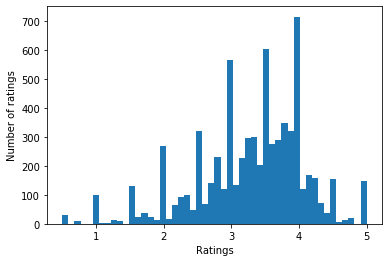

In [39]:
plt.hist(grouped_ratings['rating'], bins=50)
plt.xlabel('Ratings')
plt.ylabel('Number of ratings')

Text(0, 0.5, 'Number of movies with rating')

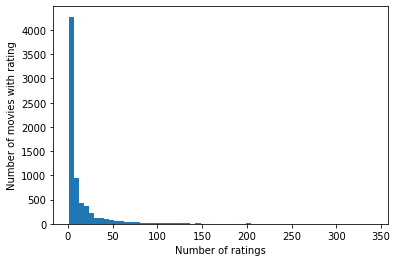

In [40]:
plt.hist(grouped_ratings['number_of_ratings'], bins=60)
plt.xlabel('Number of ratings')
plt.ylabel('Number of movies with rating')

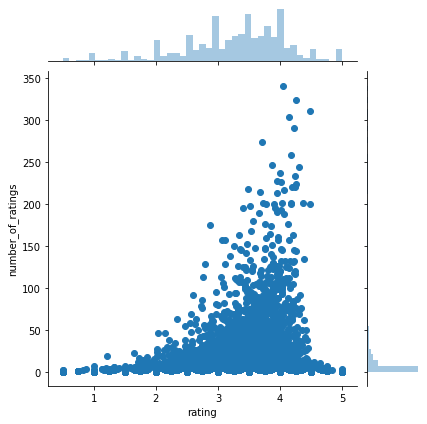

In [41]:
sns.jointplot(x='rating', y='number_of_ratings', data=grouped_ratings)


 The above shows:
 - the majority of ratings are on the higher side, from 3 to 4.
 - the majority of films have very few ratings.
 I will also show a summarised matrix of movieIds and userIds with ratings.
 This will be filtered by movies and users that have the most ratings.

In [42]:
most_rating_user = ratings_db.groupby('userId')['rating'].count()
most_rating_user = most_rating_user.sort_values(ascending=False)[:20]
high_rated = ratings_db.join(most_rating_user, rsuffix='_r', how='inner', on='userId')

In [43]:
most_rated_movies = ratings_db.groupby('movieId')['rating'].count()
most_rated_movies = most_rated_movies.sort_values(ascending=False)[:20]
high_rated = high_rated.join(most_rated_movies, rsuffix='_r', how='inner', on='movieId')

In [44]:
pd.crosstab(high_rated.userId, high_rated.movieId, high_rated.rating, aggfunc=np.sum)


movieId,1,110,260,296,318,356,457,480,527,588,589,593,608,780,1196,1198,1210,1270,2571,2858
userId,,,,,,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,5.0,3.0,4.0,0.5,4.0,5.0,5.0,2.5,5.0,4.0,5.0,5.0,5.0,4.0
23,3.0,3.5,4.5,4.5,5.0,4.5,3.5,3.5,3.5,4.0,3.5,4.5,4.5,3.5,4.5,4.5,4.0,4.5,4.0,3.5
30,4.0,5.0,4.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,3.0,5.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,4.0,5.0,5.0,3.0,4.5,4.0,3.5,5.0,5.0,5.0,5.0,4.5,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,3.0,5.0,3.0,3.0,4.0,NaN,3.0,NaN,3.0,NaN,3.0,5.0,4.0
213,3.0,2.5,5.0,NaN,NaN,2.0,4.0,5.0,NaN,3.0,4.0,2.5,2.0,5.0,5.0,3.0,5.0,3.0,4.0,NaN
294,4.0,3.0,4.0,NaN,3.0,4.0,3.5,4.0,4.0,5.0,3.0,NaN,NaN,4.5,4.0,4.5,4.0,4.0,4.5,NaN
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,4.5,5.0,3.0,4.5,2.0,4.0,4.5,3.0,4.5,3.5,4.5,4.0,NaN
380,4.0,5.0,4.0,5.0,4.0,5.0,NaN,4.0,NaN,4.0,4.0,5.0,4.0,4.0,4.0,NaN,4.0,3.0,5.0,5.0


 The next steps are taken from the notebook on SVD Matrix factorisation.

In [45]:
reader_module = Reader(rating_scale=(0.5, 5))

In [46]:
evaluation_data = surprise.Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']],reader_module)
evaluation_data.split()


In [47]:
algo = SVD()
evaluate(algo, evaluation_data)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.8972
MAE:  0.6917
------------
Fold 2
RMSE: 0.9047
MAE:  0.6957
------------
Fold 3
RMSE: 0.8943
MAE:  0.6879
------------
Fold 4
RMSE: 0.9023
MAE:  0.6946
------------
Fold 5
RMSE: 0.8858
MAE:  0.6821
------------
------------
Mean RMSE: 0.8969
Mean MAE : 0.6904
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.897230417139609,
                             0.9047234925658123,
                             0.8942703490644545,
                             0.9023251927608312,
                             0.885798724790563],
                            'mae': [0.6916965280637242,
                             0.6957230564156267,
                             0.6879470385734126,
                             0.6945940916393092,
                             0.6820971853998145]})

In [48]:
trainset = evaluation_data.build_full_trainset()


In [49]:
algo.train(trainset)


 Finally I establish the necessary steps for a hybrid recommender.
 First I create a mapping between my original small dataset and the new ratings data using the tmdbId.
 Finally I create an indexing DataFrame with the tmdbId as an index (under the guise of 'id').

In [50]:
ratings_movies_map = pd.read_csv(small_db_links)[['movieId', 'tmdbId']]
ratings_movies_map['tmdbId'] = ratings_movies_map['tmdbId'].apply(lambda row: (
    int(row) if not math.isnan(row) else np.nan))
ratings_movies_map.columns = ['movieId', 'id']
ratings_movies_map = ratings_movies_map.merge(small_complete_db[['title', 'id']], on='id').set_index('title')


In [51]:
indexing = ratings_movies_map.set_index('id').astype('int')
indexing.head()


,movieId
id,
862.0,1
8844.0,2
15602.0,3
31357.0,4
11862.0,5


 In the complete recommender function below, I use the existing functionality and create a predicted_rating field that I run the
 SVD algorithm on so every film has a predicted rating score. The final twenty suggestions are then sorted by this predicted rating
 and returned to the user.

In [52]:
def recommend_similar_popular_films_for_user(user, film, db, accepted_popularity_rating, algo):
    word_count_matrix = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')(
        .fit_transform(db['metadata_bucket']))
    title_indices = pd.Series(db.index, index=db['title'])  
    similarity_ratings = list(enumerate(cosine_similarity(word_count_matrix,word_count_matrix)[title_indices[film]]))
    sorted_ratings = sorted(similarity_ratings, key=lambda key: key[1], reverse=True)
    movie_indices = [i[0] for i in sorted_ratings]
    more_popular_movies = filter_movies_by_popularity_rating((
        accepted_popularity_rating, db.iloc[movie_indices][['title', 'popularity', 'id']]))
    more_popular_movies['movieId'] = more_popular_movies['id'].apply(lambda row: indexing.loc[row]['movieId'])
    more_popular_movies['predicted_rating'] = more_popular_movies['id'].apply(lambda row: algo.predict(user, row).est)
    more_popular_movies = more_popular_movies[['popularity', 'predicted_rating', 'title']].iloc[1:21]
    popular_matched_movies_by_rating = more_popular_movies.sort_values('predicted_rating', ascending=False)
    return popular_matched_movies_by_rating



In [67]:
print(recommend_similar_popular_films_for_user(666, 'avatar', small_complete_db, accepted_popularity_rating, algo))

      popularity  predicted_rating                              title
3531   10.223851          3.768678  final fantasy: the spirits within
8658   26.058586          3.543608         x-men: days of future past
8419   18.538834          3.543608                       man of steel
9006   20.659284          3.543608                   star trek beyond
5123   13.852147          3.543608            chitty chitty bang bang
7633   11.803808          3.543608                shrek forever after
9004   42.965027          3.543608                      suicide squad
1280   11.366417          3.543608                              spawn
8725   22.337973          3.543608       teenage mutant ninja turtles
6576   12.722120          3.543608                       the covenant
6359   10.695639          3.543608         zathura: a space adventure
6236   19.382082          3.543608                     fantastic four
2133    9.614638          3.543608                       superman iii
5310   14.612842    

In [68]:
print(recommend_similar_popular_films_for_user((
    22, 'interstellar', small_complete_db, accepted_popularity_rating, algo)))

      popularity  predicted_rating                  title
2813   11.059785          4.500779                solaris
6623   16.945560          3.672507           the prestige
4153   14.108597          3.543608         silent running
8983   25.629930          3.543608            the martian
147    15.178338          3.543608           first knight
8477   11.213913          3.543608             about time
7250    9.806904          3.543608                knowing
9217    9.285519          3.543608          shin godzilla
450     9.715187          3.543608              no escape
151    11.715868          3.543608        johnny mnemonic
1274   14.374866          3.543608                contact
4221   13.352780          3.543608             undisputed
2820   10.163266          3.543608              frequency
2043   17.784978          3.543608     planet of the apes
8031   20.582580          3.543608  the dark knight rises
8936   12.682927          3.543608       midnight special
5181   11.4783

 The results are interesting and possibly not what I had expected. Another test would be to use the KNN algorithm instead.

In [54]:
# We can try this with the KNN algorithm as well. 

similarity_options = {
    'name': 'pearson',
    'user_based': True
}

algo = surprise.KNNBasic(sim_options = similarity_options)
algo.train(trainset)


Computing the pearson similarity matrix...
Done computing similarity matrix.


In [69]:
print(recommend_similar_popular_films_for_user(656, 'avatar', small_complete_db, accepted_popularity_rating, algo))

      popularity  predicted_rating                              title
5310   14.612842          5.000000               frank herbert's dune
3531   10.223851          3.890367  final fantasy: the spirits within
8658   26.058586          3.543608         x-men: days of future past
6576   12.722120          3.543608                       the covenant
9006   20.659284          3.543608                   star trek beyond
5123   13.852147          3.543608            chitty chitty bang bang
7633   11.803808          3.543608                shrek forever after
9004   42.965027          3.543608                      suicide squad
1280   11.366417          3.543608                              spawn
8725   22.337973          3.543608       teenage mutant ninja turtles
6359   10.695639          3.543608         zathura: a space adventure
8419   18.538834          3.543608                       man of steel
6236   19.382082          3.543608                     fantastic four
2133    9.614638    

In [70]:
print(recommend_similar_popular_films_for_user((
    22, 'interstellar', small_complete_db, accepted_popularity_rating, algo)))

      popularity  predicted_rating                  title
2813   11.059785          4.500779                solaris
6623   16.945560          3.672507           the prestige
4153   14.108597          3.543608         silent running
8983   25.629930          3.543608            the martian
147    15.178338          3.543608           first knight
8477   11.213913          3.543608             about time
7250    9.806904          3.543608                knowing
9217    9.285519          3.543608          shin godzilla
450     9.715187          3.543608              no escape
151    11.715868          3.543608        johnny mnemonic
1274   14.374866          3.543608                contact
4221   13.352780          3.543608             undisputed
2820   10.163266          3.543608              frequency
2043   17.784978          3.543608     planet of the apes
8031   20.582580          3.543608  the dark knight rises
8936   12.682927          3.543608       midnight special
5181   11.4783

In [71]:
print(recommend_similar_popular_films_for_user(111, 'deadpool', small_complete_db, accepted_popularity_rating, algo))

      popularity  predicted_rating                                title
7923   19.323582          5.000000   captain america: the first avenger
7938    9.763493          3.543608                   30 minutes or less
1293   13.855037          3.543608                          money talks
4716   11.080439          3.543608                   hollywood homicide
8392   23.721243          3.543608                           iron man 3
8868   37.379420          3.543608              avengers: age of ultron
3244   12.434175          3.543608           o brother, where art thou?
7672   13.793301          3.543608          scott pilgrim vs. the world
7628   16.747793          3.543608                           the a-team
1742    9.852635          3.543608                   wrongfully accused
6256    9.039467          3.543608                 the dukes of hazzard
3715   10.921504          3.543608                              hatari!
4970    9.782014          3.543608                          huds

In [72]:
print(recommend_similar_popular_films_for_user((
    763, 'the notebook', small_complete_db, accepted_popularity_rating, algo)))

      popularity  predicted_rating                        title
7924   10.246173          3.543608         crazy, stupid, love.
4270   14.074906          3.543608               moonlight mile
5027   11.277226          3.543608                      jezebel
483    10.234919          3.543608         sleepless in seattle
6260   10.947957          3.543608             the skeleton key
7376   13.682598          3.543608     the time traveler's wife
2378   10.762325          3.543608                    indochine
417    10.687795          3.543608     the house of the spirits
8676   16.274653          3.543608       the fault in our stars
7697   10.279685          3.543608                      flipped
2667   10.891524          3.543608                  city lights
302    10.391900          3.543608  what's eating gilbert grape
4099    9.645801          3.543608            murder by numbers
2633   10.450148          3.543608                      singles
1320   12.311564          3.543608      

 This produces good results, though it does appear alot of the ratings produced are the same, this may be due to a lack of variation
 in the user and a lack of ratings for those films. Choosing more prolifically rated films and users with a higher number of ratings
 may provide a more varied result. From the matrix I presented earlier, I have selected the following.

In [56]:
print(recommend_similar_popular_films_for_user(15, 'toy story', small_complete_db, accepted_popularity_rating, algo))


      popularity  predicted_rating                              title
6736   10.529576          4.344732                 meet the robinsons
6496   18.907948          3.938577                               cars
2522   17.547693          3.543608                        toy story 2
6534   15.402378          3.543608                      monster house
7307   19.330884          3.543608                                 up
8595   16.418133          3.543608                     the lego movie
6784   11.526339          3.543608                          surf's up
5696   11.213712          3.543608    the spongebob squarepants movie
8371   14.757874          3.543608                         the croods
8432   24.823550          3.543608                    despicable me 2
7404   11.665693          3.543608  cloudy with a chance of meatballs
3016   11.834245          3.543608                        chicken run
7629   16.966470          3.543608                        toy story 3
7169   10.898525    

 As the results show, these predictions are fairly accurate to movies a user would enjoy.